In [66]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt 

In [67]:
originalImage = cv2.imread("../photos/Characters Test Pattern 688x688.tif", cv2.IMREAD_GRAYSCALE)
#originalImage = cv2.resize(originalImage, (512, 512))

In [68]:
def addSaltPeperNoise(image, saltRatio, pepperRatio):
    noisyImage = image.copy()
    numOfPixels = image.size
    numOfSaltPixels = int(saltRatio * numOfPixels)
    numOfPepperPixels = int(pepperRatio * numOfPixels)

    for i in range(numOfSaltPixels):
        x, y = np.random.randint(0, noisyImage.shape) # (row, col) = (512, 512)
        noisyImage[x][y] = 255
    
    for i in range(numOfPepperPixels):
        x, y = np.random.randint(0, noisyImage.shape) # (row, col) = (512, 512)
        noisyImage[x][y] = 0

    return noisyImage

In [69]:
def hermonicMean(image, kernelSize = 2):
    filteredImage  = np.zeros_like(image)
    padSize = kernelSize // 2
    paddedImage = np.pad(image, (padSize, padSize), mode='constant')

    # Loop through each pixel in the original image
    for i in range (padSize, image.shape[0] + padSize):
        for j in range(padSize, image.shape[1] + padSize):
            window = paddedImage[i - padSize: i+padSize+1, j - padSize: j+padSize+1] # Extract the local neighborhood (window) around the current pixel

            pixel = 0
            for r in range(window.shape[0]):
                for k in range(window.shape[1]):
                    pixel += 0 if np.isinf(1/window[r, k]) else 1/window[r, k] # Avoid division by zero by setting 0 if the reciprocal is infinity

            pixel = 0 if pixel == 0 else (kernelSize ** 2 / pixel) # Calculate the final pixel value using the harmonic mean formula

            if pixel > 255:  # Clip the pixel value to the range [0, 255]
                pixel = 255

            filteredImage[i-padSize, j-padSize]= pixel
    return filteredImage

In [ ]:
def geoMetricMean(image, kernelSize = 2):
    filteredImage  = np.zeros_like(image)
    padSize = kernelSize // 2
    paddedImage = np.pad(image, (padSize, padSize), mode='constant')

    for i in range (padSize, image.shape[0] + padSize):
        for j in range(padSize, image.shape[1] + padSize):
            window = paddedImage[i - padSize: i+padSize+1, j - padSize: j+padSize+1]

            pixel = 1
            # Calculate the product of pixel values in the window
            for r in range(window.shape[0]):
                for k in range(window.shape[1]):
                    pixel = pixel * int(window[r, k])

            pixel = pixel ** (1/(kernelSize ** 2)) # Take the geometric mean by raising the product to the power of (1 / (kernelSize^2))

            if pixel > 255:
                pixel = 255

            filteredImage[i-padSize, j-padSize]= pixel
    return filteredImage

In [70]:
# Peak Signal-to-Noise Ratio
def calcPNSR(image1, image2):  
    image1, image2 = np.float64(image1), np.float64(image2)
    mse = np.mean((image1 - image2) ** 2)   # Mean Squared Error (MSE)
    if mse == 0:
        return float('inf')
    psnr = 20 * np.log10(255.0) - 10 * np.log10(mse)

    print(f"comute pnsr: {20 * np.log10(255.0 / np.sqrt(mse))}")
    
    return round(psnr, 2)

comute pnsr: 9.680540402418691


C:\Users\Fahim Ahammed Firoz\AppData\Local\Temp\ipykernel_12748\679932520.py:14: RuntimeWarning: divide by zero encountered in divide
  pixel += 0 if np.isinf(1/window[r, k]) else 1/window[r, k] # Avoid division by zero by setting 0 if the reciprocal is infinity


comute pnsr: 12.412661898749937
comute pnsr: 2.5086480406540543


Text(0.5, 1.0, 'Geo metric Mean filtered Image (PNSR=2.51)')

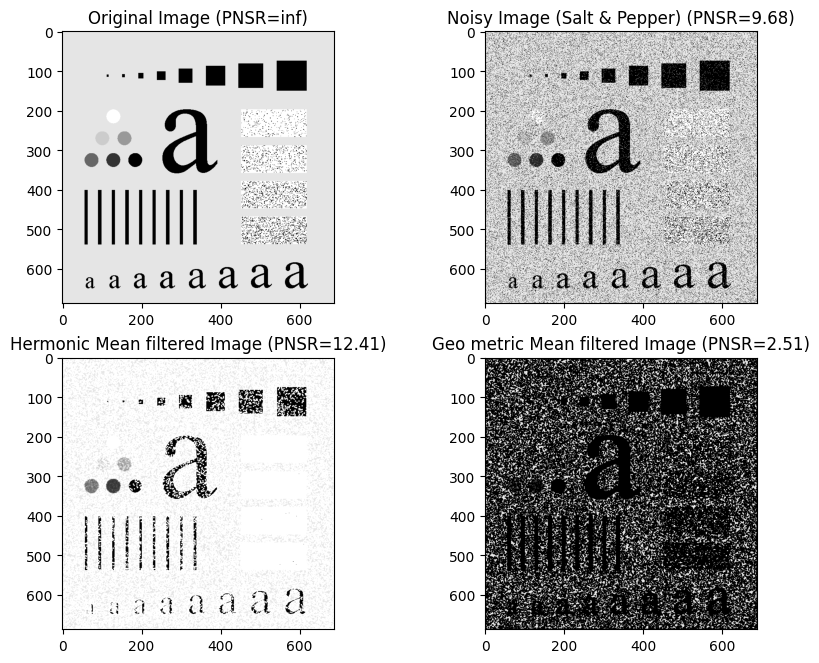

In [72]:
plt.figure(figsize=(10, 12))

plt.subplot(3, 2, 1)
plt.imshow(originalImage, cmap='gray')
plt.title(f"Original Image (PNSR={calcPNSR(originalImage, originalImage)})")

noisyImage = addSaltPeperNoise(originalImage, 0.05, 0.15)
plt.subplot(3, 2, 2)
plt.imshow(noisyImage, cmap='gray')
plt.title(f"Noisy Image (Salt & Pepper) (PNSR={calcPNSR(originalImage, noisyImage)})")

hermonicMeanFilteredImage = hermonicMean(noisyImage, 3)
plt.subplot(3, 2, 3)
plt.imshow(hermonicMeanFilteredImage, cmap='gray')
plt.title(f"Hermonic Mean filtered Image (PNSR={calcPNSR(originalImage, hermonicMeanFilteredImage)})")

geoMetricMeanFilteredImage = geoMetricMean(noisyImage, 3)
plt.subplot(3, 2, 4)
plt.imshow(geoMetricMeanFilteredImage, cmap='gray')
plt.title(f"Geo metric Mean filtered Image (PNSR={calcPNSR(originalImage, geoMetricMeanFilteredImage)})")

Determining which is better, a geometric mean filtered image or a harmonic mean filtered image, depends on several factors, including:

#### Type of noise:

- Geometric mean filter: Performs well with Gaussian noise, preserving edges and reducing noise effectively.
- Harmonic mean filter: Works best with salt and pepper noise, particularly suppressing "pepper" noise (high intensity outliers). It can also handle Gaussian noise, but not as effectively as the geometric mean filter.

#### Image features:

- Geometric mean filter: May blur edges slightly, depending on the filter size.
- Harmonic mean filter: Can sharpen edges, potentially enhancing detail, but may also amplify noise near edges.

#### Desired outcome:
- Noise reduction with edge preservation: Geometric mean filter is a better choice.
- Suppressing salt and pepper noise: Harmonic mean filter is more effective.
- Sharpening edges: Harmonic mean filter might be appropriate, but with caution due to potential noise amplification.

Ultimately, the "better" filter depends on your specific image and goals. It's best to experiment with both filters on your image and compare the results visually to see which one produces the desired outcome.

Here are some additional points to consider:

- Filter size: Both filters have a "size" parameter that controls the area considered for calculating the mean. A larger size leads to greater smoothing/sharpening but potentially more edge blurring/noise amplification.
- Other filters: Consider alternative filters like median filters, which are excellent for suppressing salt and pepper noise without blurring edges.
- Combined usage: You can even combine the outputs of different filters to achieve specific effects.